## 2.1 Building ML Model
Create a classification model to predict the class of a new gear image, 
training and validating it using the preprocessed gear image data.

In [1]:
%%time 
#1-Feature and Labels extraction
# we choose 3 img features to represent an img

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
        
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]) # 8: bins for histogram
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

# fixed-sizes for pre-processed imgs
fixed_size = tuple((128, 128))

# path to the training data
train_path = os.path.join(os.getcwd(), "dataset", "train") # ..\PyClassifier\dataset\train 

# name the training labels to be the folders names
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print("All Labels: " + str(train_labels))

# for holding features and labels vectors 
features = []
labels = []

# loop over the training data 
for root, dirs, files in os.walk(train_path): 
    # get the current training label
    current_label = os.path.basename(root)      # axes
    print("[STATUS] Processing folder: {}".format(current_label))

    # loop over the images in each sub-folder
    for file_ in files:
        # get the image file path
        file = os.path.join(root, file_) # ..\PyClassifier\dataset\train\axes\100172.jpeg

        # read the image   
        image = cv2.imread(file)
        #image = cv2.resize(image, fixed_size) # iff img is not resized
        
        # Feature extraction
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image)

        # Concatenate features
        feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        features.append(feature)

print ("[STATUS] Completed Feature Extraction.")
print("Done!")


All Labels: ['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']
[STATUS] Processing folder: train
[STATUS] Processing folder: axes
[STATUS] Processing folder: boots
[STATUS] Processing folder: carabiners
[STATUS] Processing folder: crampons
[STATUS] Processing folder: gloves
[STATUS] Processing folder: hardshell_jackets
[STATUS] Processing folder: harnesses
[STATUS] Processing folder: helmets
[STATUS] Processing folder: insulated_jackets
[STATUS] Processing folder: pulleys
[STATUS] Processing folder: rope
[STATUS] Processing folder: tents
[STATUS] Completed Feature Extraction.
Done!
Wall time: 55.3 s


In [2]:
%%time 
#2-Saving extracted Features and Labels locally

# create dir if it doesn't exist 
def mkdir_p(directory):
    if not os.path.isdir(directory):
        os.makedirs(directory)
        
# get the overall feature vector size
print ("[STATUS] Feature vector size {}".format(np.array(features).shape))

# get the overall training label size
print ("[STATUS] Training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print ("[STATUS] Training Labels encoded.")

# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(features)
print ("[STATUS] Feature vector normalized.")

print ("[STATUS] Target Labels: {}".format(target))
print ("[STATUS] Target Labels shape: {}".format(target.shape))

# save the feature vector locally using HDF5
output_path = os.path.join(os.getcwd(), "output") 
mkdir_p(output_path)

h5f_data = h5py.File(os.path.join(os.getcwd(), "output", "data.h5"), "w")
h5f_data.create_dataset("dataset_1", data=np.array(rescaled_features))

h5f_label = h5py.File(os.path.join(os.getcwd(), "output", "labels.h5"), "w")
h5f_label.create_dataset("dataset_1", data=np.array(target))

h5f_data.close()
h5f_label.close()

print ("[STATUS] Saved Features and Labels locally in dir: " + output_path)
print("Done!")


[STATUS] Feature vector size (2122, 532)
[STATUS] Training Labels (2122,)
[STATUS] Training Labels encoded.
[STATUS] Feature vector normalized.
[STATUS] Target Labels: [ 0  0  0 ... 11 11 11]
[STATUS] Target Labels shape: (2122,)
[STATUS] Saved Features and Labels locally in dir: C:\Users\Admin\PycharmProjects\PyClassifier\output
Done!
Wall time: 237 ms


In [3]:
%%time 
#3-Getting and verfying extracted Features and Labels
import glob
from matplotlib import pyplot
from sklearn.externals import joblib
 
# import the feature vector and trained labels
h5f_data = h5py.File(os.path.join(output_path, "data.h5"), "r")
h5f_label = h5py.File(os.path.join(output_path, "labels.h5"), "r")

features_string = h5f_data["dataset_1"]
labels_string = h5f_label["dataset_1"]

# converting strings to arrays
global_features  = np.array(features_string)
global_labels = np.array(labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the features and labels vector
print ("[STATUS] Features shape: {}".format(global_features.shape))
print ("[STATUS] Labels shape: {}".format(global_labels.shape))

print("Done!")


[STATUS] Features shape: (2122, 532)
[STATUS] Labels shape: (2122,)
Done!
Wall time: 241 ms


In [4]:
%%time 
#4-Splitting data into train and test

from sklearn.model_selection import train_test_split

# train_test_split size # 0.2 = 20% test data and 80% train data
test_size = 0.2
 
# for reproducing fixed results on next run, as the default is random nb and will change results
seed = 42 # 42 is common used

# split the training and testing data
(trainingData, testingData, trainingLabels, testingLabels) = train_test_split(np.array(global_features),
                                                                              np.array(global_labels),
                                                                              test_size=test_size,
                                                                              random_state=seed)

print ("[STATUS] Splitted data into training and testing.")
print ("Train data  : {}".format(trainingData.shape))
print ("Test data   : {}".format(testingData.shape))
print ("Train Labels: {}".format(trainingLabels.shape))
print ("Test Labels : {}".format(testingLabels.shape))

print("Done!")


[STATUS] Splitted data into training and testing.
Train data  : (1697, 532)
Test data   : (425, 532)
Train Labels: (1697,)
Test Labels : (425,)
Done!
Wall time: 33 ms


LR: 0.605754 (0.042506)
LDA: 0.689450 (0.028363)
KNN: 0.609328 (0.057704)
CART: 0.668830 (0.028282)
RF: 0.789635 (0.043350)
NB: 0.317014 (0.026877)
SVM: 0.218646 (0.038173)


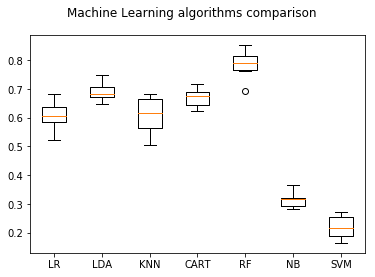

Wall time: 51.2 s


In [5]:
%%time
#5-Choosing the best Classifier using K-Fold tech

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
import warnings

warnings.filterwarnings('ignore') # filter all the warnings

# machine learning models list 
#Logistic Regression
#Linear Discriminant Analysis
#K-Nearest Neighbors
#Decision Trees
#Random Forests
#Gaussian Naive Bayes
#Support Vector Machine

models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=9))) # 100: no.of.trees 
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))

# variables to hold the results and names
results = []
names = []

# 10-fold cross validation 
for name, model in models:
    kfold = KFold(n_splits=10, random_state=0)
    cv_results = cross_val_score(model, trainingData, trainingLabels, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithms comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()
 

In [6]:
%%time
#6-Building a Classification model using the most accurate Classifier > Random Forest with 78.9 % 
import matplotlib.pyplot as plt
 
classifier = RandomForestClassifier(n_estimators=100, random_state=9)

# to try other classifiers, just replace the above statement with the intended classifier, like:
#classifier = neighbors.KNeighborsClassifier()  #KNN
#classifier = DecisionTreeClassifier() # Decision Tree

# fit the training data to the model
classifier.fit(trainingData, trainingLabels)

# get predictions
predicted = classifier.predict(testingData)  

print('Done!')


Done!
Wall time: 1.17 s


## 2.2 Calculating metrics of the best model

Confusion Matrix
[[14  0  1  1  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  1  0  0  0  0  0  0]
 [ 0  0 56  1  0  1  2  0  0  0  1  0]
 [ 0  0  3 21  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 25  8  1  0  2  0  0  1]
 [ 0  0  1  0  2 76  0  0  9  0  0  0]
 [ 0  1  1  0  1  1 30  0  0  0  0  0]
 [ 0  0  0  0  0  6  1 10  0  0  0  1]
 [ 0  0  1  0  3 14  0  0 29  0  0  0]
 [ 0  1  0  0  0  3  3  3  0  1  0  0]
 [ 0  0  3  0  0  4  0  0  2  0 36  0]
 [ 1  0  4  0  0  1  0  0  0  0  1 20]]


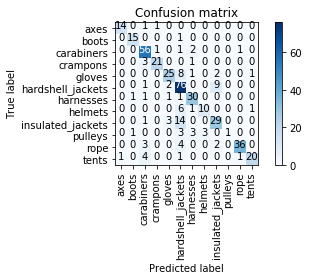

                   precision    recall  f1-score   support

             axes       0.93      0.88      0.90        16
            boots       0.88      0.94      0.91        16
       carabiners       0.80      0.92      0.85        61
         crampons       0.91      0.84      0.87        25
           gloves       0.81      0.68      0.74        37
hardshell_jackets       0.66      0.86      0.75        88
        harnesses       0.79      0.88      0.83        34
          helmets       0.77      0.56      0.65        18
insulated_jackets       0.69      0.62      0.65        47
          pulleys       1.00      0.09      0.17        11
             rope       0.95      0.80      0.87        45
            tents       0.91      0.74      0.82        27

        micro avg       0.78      0.78      0.78       425
        macro avg       0.84      0.73      0.75       425
     weighted avg       0.80      0.78      0.78       425

Accuracy = 0.7835294117647059
Done!


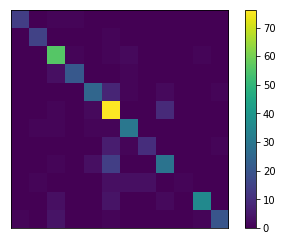

In [7]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title="Confusion matrix", cmap=plt.cm.Blues):
    print("Confusion Matrix")
    print(cm)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

# Confusion Matrix
expected  = testingLabels # renaming just for clearifying
cnf_matrix = confusion_matrix(expected, predicted )
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=train_labels, title="Confusion matrix")
 
plt.show()
plt.imshow(cnf_matrix)
plt.xticks([])
plt.yticks([])
plt.colorbar()


#precision + recall + f1-score + support + micro/macro/weighted avg 
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(expected, predicted, target_names=train_labels))
 
#Overall Accuracy of the Model    
acc= accuracy_score(expected, predicted)
print("Accuracy = " + str(acc))

print("Done!")

## 2.3 Testing the Model with New Data

In [8]:
%%time
#Preparing new data to test the model

import os
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

def resize_with_padding(img, desired_size):
    old_size = img.size  # old_size[0] is in (width, height) format
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    img = img.resize(new_size, Image.ANTIALIAS)

    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))

    resized_image = ImageOps.expand(img, padding, (255, 255, 255))  
    return resized_image

# downloaded 12 images from the given links and saved them to "gear_images_new" folder
# get new images from the "gear_images_new" folder
root_dir = os.path.join(os.getcwd(), 'gear_images_new')    # ..\PyClassifier\gear_images_new

# save pre-processed images in the "test" folder for later Model testing 
save_dir = os.path.join(os.getcwd(), "dataset", "test")    # ..\PyClassifier\dataset\test
mkdir_p(save_dir)
desired_size = 128

#apply pre-processing (resizing) steps as b4 
for root, dirs, files in os.walk(root_dir):
    dirName = os.path.basename(root)  # gear_images_new
    for file_ in files:
        print("Processing Image: " + file_)  
        imgPath = os.path.join(root, file_)  #..\PyClassifier\gear_images_new\210074_Mini_Pearbiner_Screwgate_Carabiner_web.jpg
        img = Image.open(imgPath)

        output_image_path = os.path.join(save_dir, file_)   

        resized_image = resize_with_padding(img, desired_size)
        resized_image.save(output_image_path)
        
print("Done!")

Processing Image: 210283_Positron_Screwgate_Carabiner_web.jpg
Processing Image: 210291_RockLock_Magnetron_Carabiner_web.jpg
Processing Image: 235352i_ts.jpg
Processing Image: 5112000000.jpg
Processing Image: 62379.jpg
Processing Image: 673942i3_ts.jpg
Processing Image: 698092_ts.jpg
Processing Image: 810151_firstlight_wsbi_web.jpg
Processing Image: eng_pl_-Ice-climbing-axe-Ergo-6348_1.jpg
Processing Image: head-sensor-ski-helmet-blk-16.jpg
Processing Image: jamet-geodia-tent-3.jpg
Processing Image: Little-Gloss-Ski-Helmet-WORKER.jpg
Done!
Wall time: 865 ms


Wall time: 666 ms


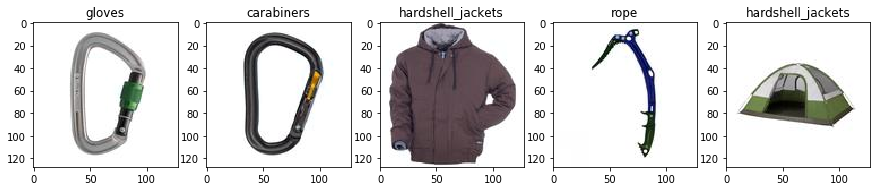

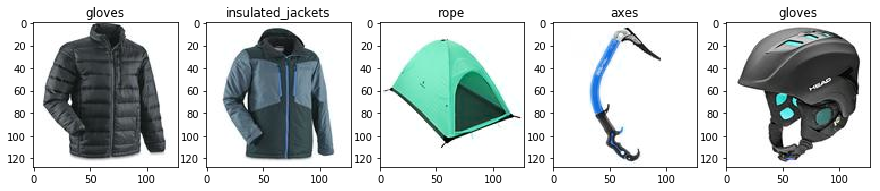

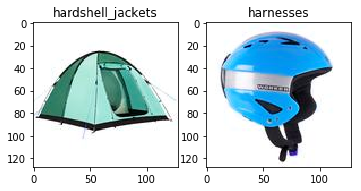

In [9]:
%%time

# display img plots as a grid
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(5,5)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])
            
# path to test data
test_path = os.path.join(os.getcwd(), "dataset", "test")  # ..\PyClassifier\dataset\test

images=[] #list of imgs
titles=[] #list of imgs' titles predicted

# loop through the test images
for file in glob.glob(os.path.join(test_path, "*.*")):
    # read the image
    image = cv2.imread(file)
    #image = cv2.resize(image, fixed_size) # iff img is not resized

    # Global Feature extraction
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    # Concatenate global features
    feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # predict label of test image
    prediction = classifier.predict(feature.reshape(1,-1))[0]
    
    images.append(image)
    titles.append(train_labels[prediction])

grid_display(images, titles, 5, (15,15))
